# FAST + KLT

In [11]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import os
%matplotlib inline

# Mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
# Load the image
image_path="/content/gdrive/My Drive/FAST/"
old_image = cv2.imread(os.path.join(image_path,'35.jpg'))
new_image = cv2.imread(os.path.join(image_path,'34.jpg'))

# Convert image to RGB
old_image = cv2.cvtColor(old_image, cv2.COLOR_BGR2RGB)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)

# Convert image to gray scale
old_gray = cv2.cvtColor(old_image, cv2.COLOR_RGB2GRAY)
new_gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY) 

# Apply Gaussian Blur
old_blur = cv2.GaussianBlur(old_gray,(11,11),0)
new_blur = cv2.GaussianBlur(new_gray,(11,11),0)

In [13]:
fast = cv2.FastFeatureDetector_create() 

# Detect keypoints with non max suppression
keypoints_with_nonmax = fast.detect(old_blur, None)

# Image to draw keypoint on
image_with_nonmax = np.copy(old_image)

# Draw keypoints on top of the input image
cv2.drawKeypoints(old_image, keypoints_with_nonmax, image_with_nonmax, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without non max suppression
#plt.imshow(image_with_nonmax)
#plt.title("With non max suppression")
#plt.show()

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Image With Non Max Suppression: ", len(keypoints_with_nonmax))

Number of Keypoints Detected In The Image With Non Max Suppression:  55


In [14]:
# Mask image for track to draw on
mask = np.zeros_like(old_image) 

# Parameters for lucas kanade optical flow 
lk_params = dict( winSize = (15, 15), 
                  maxLevel = 2, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 
                              10, 0.03)) 

# Convert keypoint 2D array to 3D array  
keypoints_with_nonmax = cv2.KeyPoint_convert(keypoints_with_nonmax)
p0 = np.expand_dims(keypoints_with_nonmax, axis=1)

# calculate optical flow 
p1, st, err = cv2.calcOpticalFlowPyrLK(old_blur, 
                                        new_blur, 
                                        p0, None, 
                                        **lk_params) 

# Select good points 
good_new = p1[st == 1] 
good_old = p0[st == 1] 

print(good_old)
print(good_new)

# Create some random colors 
color = np.random.randint(0, 255, (100, 3)) 



[[118.  25.]
 [ 39.  26.]
 [150.  53.]
 [420. 107.]
 [212. 118.]
 [188. 145.]
 [481. 151.]
 [110. 182.]
 [  5. 194.]
 [156. 196.]
 [232. 230.]
 [746. 236.]
 [111. 240.]
 [131. 241.]
 [109. 245.]
 [274. 252.]
 [174. 288.]
 [212. 289.]
 [174. 290.]
 [168. 291.]
 [209. 293.]
 [211. 295.]
 [186. 301.]
 [185. 305.]
 [189. 312.]
 [185. 313.]
 [195. 314.]
 [198. 331.]
 [206. 332.]
 [204. 333.]
 [206. 341.]
 [212. 349.]
 [197. 352.]
 [214. 362.]
 [364. 362.]
 [214. 375.]
 [229. 378.]
 [211. 380.]
 [215. 380.]
 [207. 381.]
 [219. 387.]
 [  6. 389.]
 [213. 394.]
 [217. 395.]
 [219. 396.]
 [ 22. 403.]
 [499. 409.]
 [256. 461.]
 [148. 505.]
 [148. 507.]
 [120. 510.]
 [ 94. 626.]]
[[ 2.32984695e+02  4.93249016e+01]
 [ 1.13432335e+02  2.72265873e+01]
 [ 1.63841980e+02  6.56584167e+00]
 [ 3.67507660e+02  1.50772827e+02]
 [ 2.24431732e+02  1.76098724e+02]
 [ 2.05993790e+02  1.85560150e+02]
 [ 5.09198975e+02  1.44707169e+02]
 [ 2.42427750e+02  3.37621918e+02]
 [ 6.56657219e-01  1.66030014e+02]
 [ 1.709

True

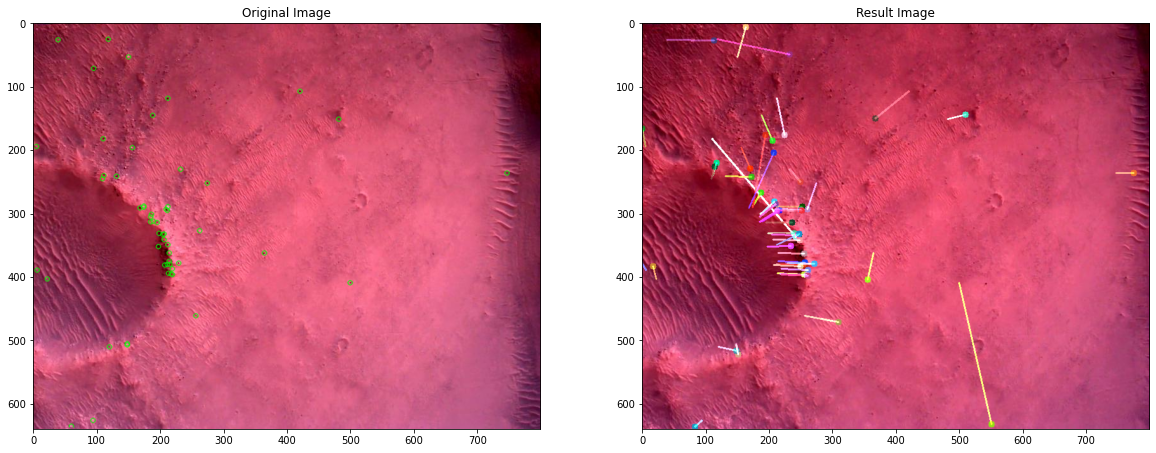

In [15]:
# draw the tracks 
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = (int(x) for x in new.ravel())
    c, d = (int(x) for x in old.ravel())
    mask = cv2.line(mask, (a, b), (c, d), color[i].tolist(), 2)
    frame = cv2.circle(new_image, (a, b), 5, color[i].tolist(), -1)

# merge mask and new image together
img = cv2.add(frame, mask)

# Display image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Original Image")
plots[0].imshow(image_with_nonmax)

plots[1].set_title("Result Image")
plots[1].imshow(img)

# Save image
cv2.imwrite(os.path.join(image_path,'35-FAST.jpg'),image_with_nonmax)
cv2.imwrite(os.path.join(image_path,'34-KLT.jpg'),img)